In [1]:
!wget https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl

--2023-05-15 18:08:29--  https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl
Resolving nvlabs-fi-cdn.nvidia.com (nvlabs-fi-cdn.nvidia.com)... 13.35.7.26, 13.35.7.50, 13.35.7.45, ...
Connecting to nvlabs-fi-cdn.nvidia.com (nvlabs-fi-cdn.nvidia.com)|13.35.7.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 381624121 (364M) [binary/octet-stream]
Saving to: ‘ffhq.pkl’

ffhq.pkl            100%[===================>] 363.94M   144MB/s    in 2.5s    

2023-05-15 18:08:33 (144 MB/s) - ‘ffhq.pkl’ saved [381624121/381624121]



In [2]:
!pip install gdown
!gdown 1FZfl7b7BhfIrWA_gp9rDaduDNlZcW0z6
!gdown 1xcZy26mlmGBlUe1CWSxkqkXdpc9xwyh1
!gdown 1_dqKombr3mZJeJoaRMN6tds7enF2mPL6

Downloading...
From: https://drive.google.com/uc?id=1FZfl7b7BhfIrWA_gp9rDaduDNlZcW0z6
To: /kaggle/working/ganspace_stylegan_components.csv
100%|██████████████████████████████████████| 6.53M/6.53M [00:00<00:00, 17.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1xcZy26mlmGBlUe1CWSxkqkXdpc9xwyh1
To: /kaggle/working/A.csv
100%|██████████████████████████████████████| 6.69M/6.69M [00:00<00:00, 16.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1_dqKombr3mZJeJoaRMN6tds7enF2mPL6
To: /kaggle/working/A_2000.csv
100%|██████████████████████████████████████| 6.69M/6.69M [00:00<00:00, 15.8MB/s]


In [3]:
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch

Cloning into 'stylegan2-ada-pytorch'...
remote: Enumerating objects: 128, done.
remote: Total 128 (delta 0), reused 0 (delta 0), pack-reused 128
Receiving objects: 100% (128/128), 1.12 MiB | 4.16 MiB/s, done.
Resolving deltas: 100% (57/57), done.


In [4]:
%cd stylegan2-ada-pytorch

/kaggle/working/stylegan2-ada-pytorch


In [5]:
import torch
import numpy as np

import pickle
import os

import matplotlib.pyplot as plt

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
with open('/kaggle/working/ffhq.pkl', 'rb') as f:
    G = pickle.load(f)['G_ema'].to(device) 

In [8]:
def gen_samples(path, G, n_samples, batch_size, device):
    n_iter = n_samples // batch_size
    for i in range(n_iter):
        z = torch.randn([batch_size, G.z_dim]).to(device)
        w = G.mapping(z, None)[:, 0]

        if os.path.exists(path):
            with open(path, "ab") as f:
                np.savetxt(f, w.detach().cpu().numpy(), delimiter=",")
        else:
            np.savetxt(path, w.detach().cpu().numpy(), delimiter=",")
    return np.loadtxt(os.path.join(path), delimiter=",")

In [9]:
from sklearn.decomposition import PCA

In [10]:
path = "/kaggle/working/ganspace_stylegan_components.csv"
if os.path.exists(path):
    pc = np.loadtxt(path, delimiter=",")
else:
    n_samples = 100000
    batch_size = 50
    vectors = gen_samples(path, G, n_samples, batch_size, device)
    pca = PCA(n_components=500)
    pca.fit(vectors)
    pc = pca.components_

In [11]:
pc.shape

(500, 512)

In [12]:
z = torch.randn([5, G.z_dim]).to(device)

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


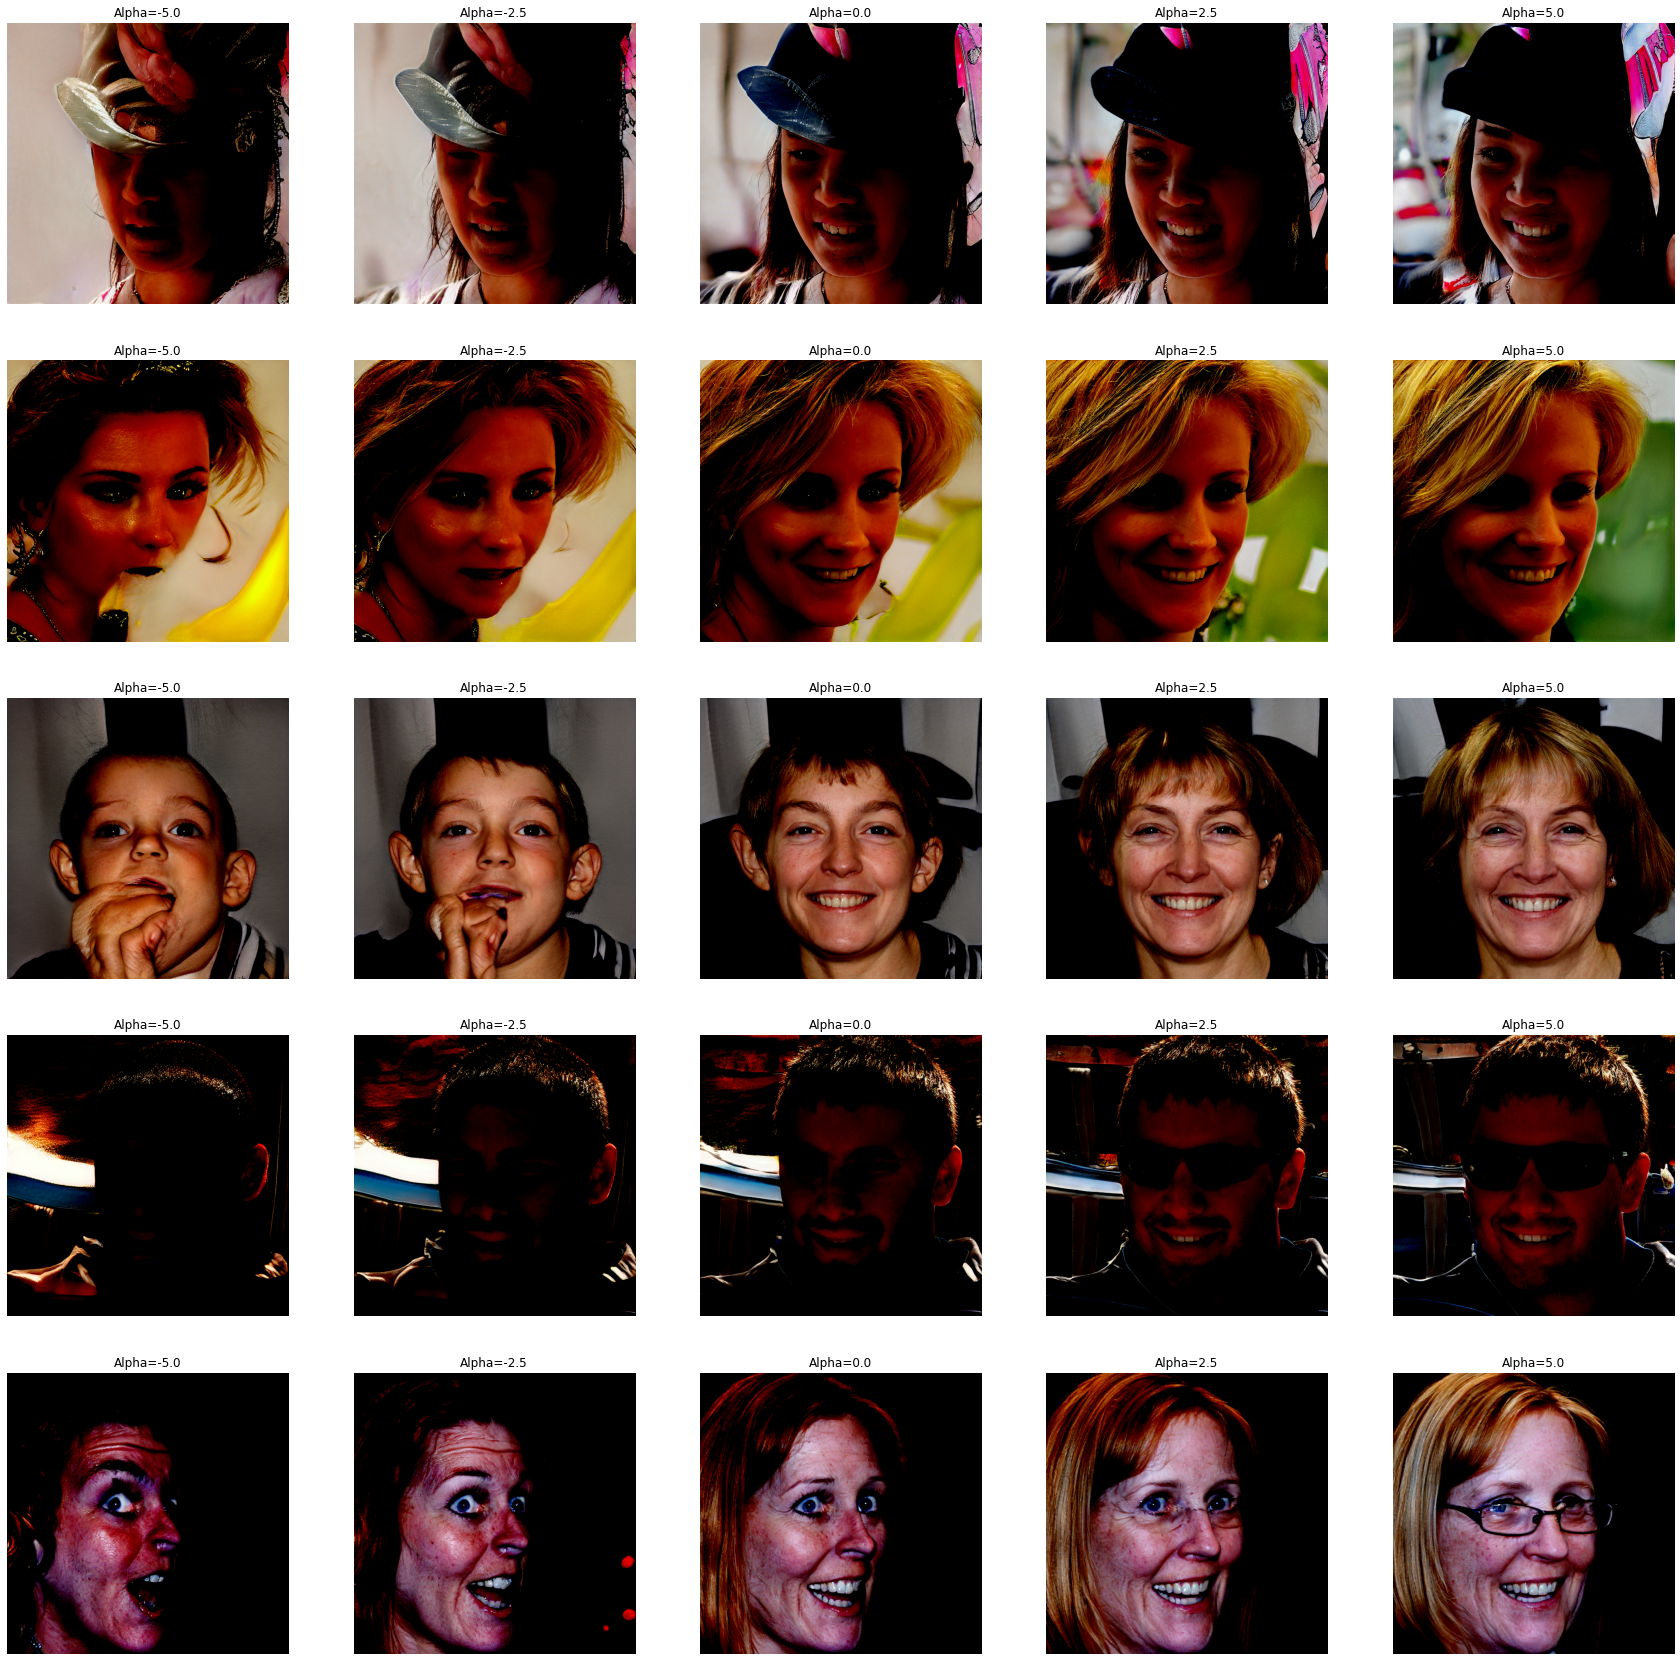

In [13]:
alphas = np.linspace(-5, 5, 5)
edits = torch.tensor(alphas.reshape(-1,1)*pc[9]).to(device)
edits = edits.unsqueeze(1).repeat_interleave(18, dim=1)
fig, axs = plt.subplots(5,5, figsize=(30,30))

for idx in range(5):
    w = G.mapping(z[idx].unsqueeze(0), None)
    w_edits = w.repeat(5, 1, 1)
    w_edits[:, :]+=edits[:, :]
    for i, w_edit in enumerate(w_edits):
        img = G.synthesis(w_edit.unsqueeze(0))[0]
        out = img.permute([1,2,0]).detach().cpu().numpy()
        axs[idx, i].axis('off')
        axs[idx, i].imshow(out)
        axs[idx, i].set_title(f"Alpha={alphas[i]}")

In [14]:
z_list = []
batch_size=10
for i in range(100):
    z_list.append(torch.randn([batch_size, G.z_dim]))

In [15]:
import os
from tqdm import tqdm
from torchvision.utils import save_image

In [16]:
%cd /kaggle/working

/kaggle/working


In [17]:
os.makedirs("original", exist_ok=True)
for i in tqdm(range(100)):
    z = z_list[i].to(device)
    
    imgs = G(z, None)
    for idx, img in enumerate(imgs):
        save_image(img, f'original/img{i*batch_size+idx}.png')

100%|██████████| 100/100 [06:05<00:00,  3.66s/it]


In [19]:
batch_size=10
os.makedirs("ganspace_stylegan", exist_ok=True)
for i in tqdm(range(100)):
    z = z_list[i].to(device)
    c = torch.randint(0, 20, [batch_size], device='cuda')
    shifts = torch.randn(c.shape, device='cuda')

    shifts = 6.0 * shifts
    shifts[(shifts < 0.5) & (shifts > 0)] = 0.5
    shifts[(shifts > -0.5) & (shifts < 0)] = -0.5
    edits = torch.zeros([batch_size, G.z_dim], device='cuda')
    for idx in range(batch_size):
        edits[idx] = shifts[idx] * torch.tensor(pc[c[idx]], device="cuda")
    
    imgs = G(z, None)
    w = G.mapping(z, None)
    imgs_shifted = G.synthesis(w+edits.unsqueeze(1))
    for idx, img_shifted in enumerate(imgs_shifted):
        save_image(img_shifted, f'ganspace_stylegan/img{i*batch_size+idx}.png')

100%|██████████| 100/100 [06:43<00:00,  4.03s/it]


In [20]:
!pip install pytorch-fid

In [21]:
!python -m pytorch_fid /kaggle/working/ganspace_stylegan /kaggle/working/original

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100%|██████████████████████████████████████| 91.2M/91.2M [00:02<00:00, 39.2MB/s]
100%|███████████████████████████████████████████| 20/20 [00:44<00:00,  2.24s/it]
FID:  32.792765188869396
